<a href="https://colab.research.google.com/github/bvchand/Diabetes-detection-in-ICU-patients/blob/main/diabetes_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sqlite3
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from fancyimpute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd '/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021'

/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021


## Data Preprocessing

In [4]:
diabetes_train = pickle.load(open("diabetes_train.pkl", "rb"))

### Handling categorical values

In [5]:
diab_train_df = diabetes_train.loc[:, diabetes_train.columns != 'diabetes_mellitus']
diab_train_target = diabetes_train['diabetes_mellitus']
diab_train_df = diab_train_df.drop(columns='Unnamed: 0')

In [6]:
diab_train_df.columns

Index(['encounter_id', 'hospital_id', 'age', 'bmi', 'elective_surgery',
       'ethnicity', 'gender', 'height', 'hospital_admit_source',
       'icu_admit_source',
       ...
       'h1_arterial_po2_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min',
       'aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis'],
      dtype='object', length=179)

In [7]:
# features that are categorical

for cols in diab_train_df.columns:
    if(diab_train_df[cols].dtype == object):
        print("{0} : {1}".format(cols, diab_train_df[cols].dtype))

ethnicity : object
gender : object
hospital_admit_source : object
icu_admit_source : object
icu_stay_type : object
icu_type : object


In [8]:
diab_train_df[['ethnicity','gender','hospital_admit_source','icu_admit_source','icu_type']]

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_type
0,Caucasian,M,Floor,Floor,CTICU
1,Caucasian,F,Floor,Floor,Med-Surg ICU
2,Caucasian,F,Emergency Department,Accident & Emergency,Med-Surg ICU
3,Caucasian,F,Operating Room,Operating Room / Recovery,CTICU
4,Caucasian,M,NaN,Accident & Emergency,Med-Surg ICU
...,...,...,...,...,...
130152,Caucasian,M,Emergency Department,Accident & Emergency,Cardiac ICU
130153,Caucasian,F,Direct Admit,Accident & Emergency,MICU
130154,African American,M,Emergency Department,Accident & Emergency,Cardiac ICU
130155,Caucasian,M,Emergency Department,Accident & Emergency,Med-Surg ICU


In [9]:
# unique values in the categorical columns

obj_cols = {'ethnicity','gender','hospital_admit_source','icu_admit_source','icu_type', 'icu_stay_type'}
for col in obj_cols:
    print("{0}: {1}".format(col, diab_train_df[col].unique()))
    print()

ethnicity: ['Caucasian' nan 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown']

icu_admit_source: ['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan]

gender: ['M' 'F' nan]

icu_stay_type: ['admit' 'readmit' 'transfer']

icu_type: ['CTICU' 'Med-Surg ICU' 'CCU-CTICU' 'Neuro ICU' 'MICU' 'SICU'
 'Cardiac ICU' 'CSICU']

hospital_admit_source: ['Floor' 'Emergency Department' 'Operating Room' nan 'Direct Admit'
 'Other Hospital' 'Other ICU' 'ICU to SDU' 'Recovery Room'
 'Chest Pain Center' 'Step-Down Unit (SDU)' 'Acute Care/Floor' 'PACU'
 'Observation' 'ICU' 'Other']



#### Handling missing values for 'gender':



In [10]:
diab_train_df[['gender']].head()

,gender
0,M
1,F
2,F
3,F
4,M


In [11]:
diab_train_df['gender'].isnull().sum()

66

In [12]:
diab_train_df['gender'] = diab_train_df['gender'].fillna(method='ffill')

In [13]:
diab_train_df['gender'].isnull().sum()

0

#### Handling missing values for 'ethnicity':



In [14]:
diab_train_df['ethnicity'].isnull().sum()

1587

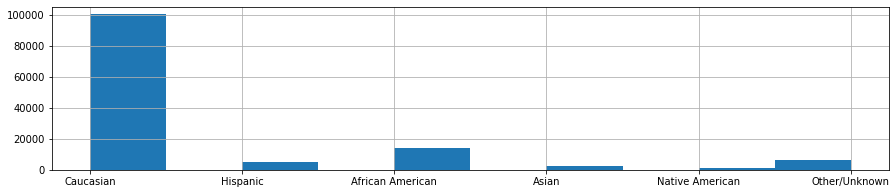

In [15]:
diab_train_df['ethnicity'].hist(figsize=(15,3))

In [16]:
diab_train_df['ethnicity'].replace(np.nan, "Unknown/Other(preprocessed)", inplace=True)
diab_train_df['ethnicity'].isnull().sum()

0

#### Handling missing values for 'icu_type':



In [17]:
diab_train_df['icu_type'].isnull().sum()

0

#### Handling missing values for 'icu_admit_source':



In [18]:
diab_train_df['icu_admit_source'].isnull().sum()

240

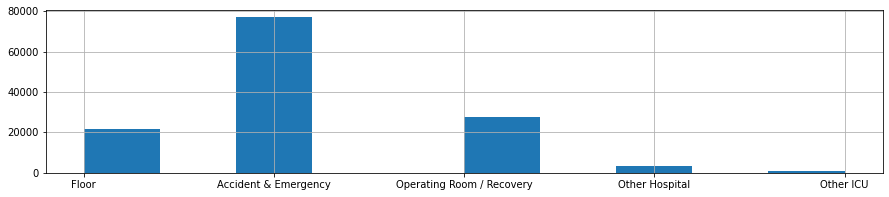

In [19]:
diab_train_df['icu_admit_source'].hist(figsize=(15,3))

In [20]:
diab_train_df['icu_admit_source'].replace(np.nan, "Unknown/Other(preprocessed)", inplace=True)
diab_train_df['icu_admit_source'].isnull().sum()

0

#### Handling missing values for 'hospital_admit_source':



In [21]:
diab_train_df['hospital_admit_source'].isnull().sum()

33198

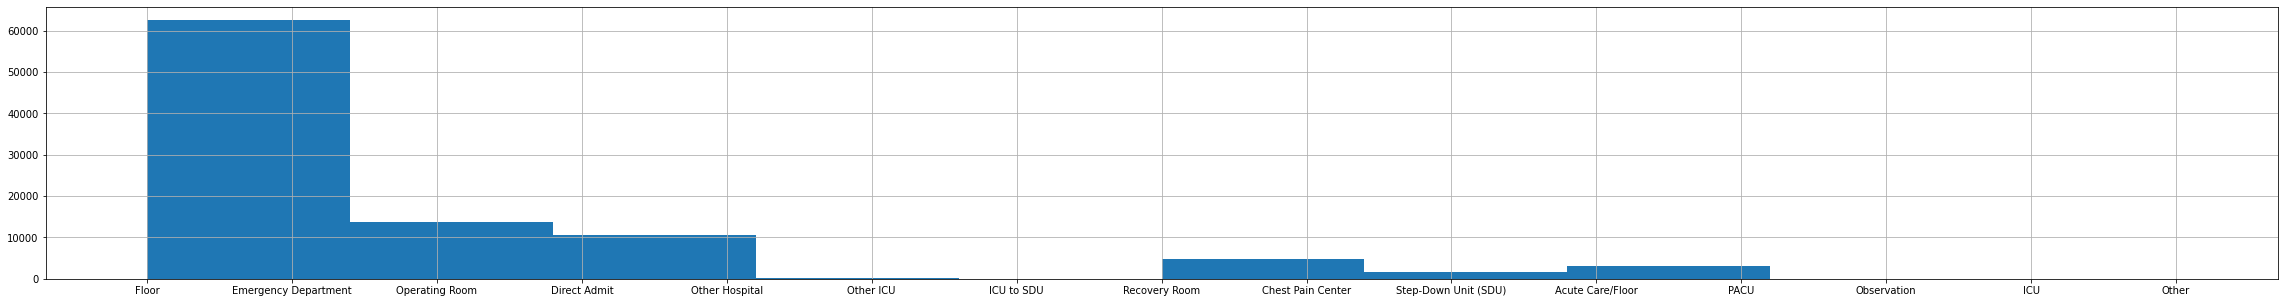

In [22]:
diab_train_df['hospital_admit_source'].hist(figsize=(40,5))

In [23]:
diab_train_df['hospital_admit_source'].replace(np.nan, "Unknown/Other(preprocessed)", inplace=True)
diab_train_df['hospital_admit_source'].isnull().sum()

0

#### Handling missing values for 'icu_stay_type':



In [24]:
diab_train_df['icu_stay_type'].isnull().sum()

0

In [25]:
for col in obj_cols:
    print("{0}: {1}\n".format(col, diab_train_df[col].unique()))

ethnicity: ['Caucasian' 'Unknown/Other(preprocessed)' 'Hispanic' 'African American'
 'Asian' 'Native American' 'Other/Unknown']

icu_admit_source: ['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' 'Unknown/Other(preprocessed)']

gender: ['M' 'F']

icu_stay_type: ['admit' 'readmit' 'transfer']

icu_type: ['CTICU' 'Med-Surg ICU' 'CCU-CTICU' 'Neuro ICU' 'MICU' 'SICU'
 'Cardiac ICU' 'CSICU']

hospital_admit_source: ['Floor' 'Emergency Department' 'Operating Room'
 'Unknown/Other(preprocessed)' 'Direct Admit' 'Other Hospital' 'Other ICU'
 'ICU to SDU' 'Recovery Room' 'Chest Pain Center' 'Step-Down Unit (SDU)'
 'Acute Care/Floor' 'PACU' 'Observation' 'ICU' 'Other']



### Encoding categorical features:

In [26]:
enc = LabelEncoder()
for cols in obj_cols:
    diab_train_df[cols] = enc.fit_transform(diab_train_df[cols])    

In [27]:
for col in obj_cols:
    print("{0}: {1}".format(col, diab_train_df[col].unique()))

ethnicity: [2 6 3 0 1 4 5]
icu_admit_source: [1 0 2 3 4 5]
gender: [1 0]
icu_stay_type: [0 1 2]
icu_type: [2 5 0 6 4 7 3 1]
hospital_admit_source: [ 4  3  8 15  2 10 11  6 13  1 14  0 12  7  5  9]


In [28]:
#https://www.kaggle.com/danofer/apache-iiij-icu-diagnosis-codes?select=icu-apache-codes-ANZICS.csv
#apache2 and apache3 data is present in this dataset, there is redundant information
#Action: drop the apache2 data, apache3 is more fine grained according to below paper:
#reference- https://pubmed.ncbi.nlm.nih.gov/11579607/#:~:text=Results%3A%20Both%20systems%20showed%20a,0.6856%3B%20p%20%3C%200.05).
diab_train_df['apache_3j_diagnosis'] = (diab_train_df.apache_3j_diagnosis).fillna(0).astype(int)
if "apache_2_diagnosis" in diab_train_df.columns:
  diab_train_df = diab_train_df.drop("apache_2_diagnosis",axis=1)

#we can drop readmission status
if "readmission_status" in diab_train_df.columns:
  diab_train_df = diab_train_df.drop("readmission_status",axis=1)

### Handling null values for 'age'

In [29]:
#for missing age (age=0), replace them with mean age
diab_train_df['age']=diab_train_df['age'].astype(str).astype(float)
val = diab_train_df['age'].mean()
diab_train_df['age'] = diab_train_df['age'].replace(0, val)
diab_train_df["age"] = diab_train_df["age"].fillna(val)
diab_train_df["age"].isnull().sum()


0

# Drop cols with null values

In [30]:
diab_train_reduced = diab_train_df.copy(deep=True)

In [31]:
def missing_percentage(df):
    missing_count=df.isnull().sum()
    missing_df = (pd.concat([missing_count.rename('Missing count'),missing_count.div(len(df))
                .rename('Missing percent')],axis = 1))
    missing_df.style.background_gradient(cmap="Blues")

    return missing_df

In [32]:
missing_df = missing_percentage(diab_train_df)
missing_df

,Missing count,Missing percent
encounter_id,0,0.000000
hospital_id,0,0.000000
age,0,0.000000
bmi,4490,0.034497
elective_surgery,0,0.000000
...,...,...
hepatic_failure,0,0.000000
immunosuppression,0,0.000000
leukemia,0,0.000000
lymphoma,0,0.000000


In [33]:
cols_above_threshold = missing_df[missing_df['Missing percent']>0.4]

In [34]:
cols_above_threshold

,Missing count,Missing percent
albumin_apache,78163,0.600529
bilirubin_apache,82560,0.634311
fio2_apache,99720,0.766152
paco2_apache,99720,0.766152
paco2_for_ph_apache,99720,0.766152
...,...,...
h1_arterial_ph_min,107849,0.828607
h1_arterial_po2_max,107445,0.825503
h1_arterial_po2_min,107445,0.825503
h1_pao2fio2ratio_max,113397,0.871232


In [35]:
diab_train_reduced.drop(columns=cols_above_threshold.index, inplace=True)

### Dropping columns that don't have an effect on the target variable

In [36]:
columns_to_drop = ['hospital_id','elective_surgery','icu_id','icu_stay_type','icu_type','aids','cirrhosis','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis']

In [37]:
diab_train_reduced.drop(columns=columns_to_drop, inplace=True)

In [38]:
from sklearn.model_selection import train_test_split
train_X,test_X,train_y,test_y = train_test_split(diab_train_reduced, diab_train_target, test_size=0.2)

In [39]:
diab_train_reduced.info

<bound method DataFrame.info of         encounter_id   age        bmi  ...  d1_sodium_min  d1_wbc_max  d1_wbc_min
0             214826  68.0  22.732803  ...          134.0        14.1        14.1
1             246060  77.0  27.421875  ...          145.0        23.3        12.7
2             276985  25.0  31.952749  ...            NaN         NaN         NaN
3             262220  81.0  22.635548  ...            NaN         9.0         8.0
4             201746  19.0        NaN  ...            NaN         NaN         NaN
...              ...   ...        ...  ...            ...         ...         ...
130152        164758  50.0  29.287256  ...            NaN         NaN         NaN
130153        197653  79.0  29.653433  ...          140.0        10.4         9.5
130154        219719  73.0  32.265371  ...          139.0        41.8        20.4
130155        222562  81.0  24.408579  ...          141.0        15.3        15.3
130156        157942  35.0  30.132358  ...          135.0         

In [40]:
pickle.dump(diab_train_reduced, open("diab_train_reduced.pkl", "wb"))


## Imputing null values for non-categorical features

In [41]:
trainX_copy_wo_age = pd.DataFrame(train_X) 
trainX_copy_wo_age = trainX_copy_wo_age.drop(columns='age')
# imputer = KNNImputer(n_neighbors=30)
# %time
# KNN_imputed_trainX_wo_age = imputer.fit_transform(trainX_copy_wo_age)


# pickle.dump(KNN_imputed_trainX_wo_age, open("KNN_imputed_trainX_wo_age.pkl", "wb"))
KNN_imputed_trainX_wo_age_pkl = pickle.load(open("KNN_imputed_trainX_wo_age.pkl", "rb"))

In [42]:
KNN_imputed_trainX_wo_age_df = pd.DataFrame(KNN_imputed_trainX_wo_age_pkl, columns=trainX_copy_wo_age.columns)

In [43]:
KNN_imputed_trainX_wo_age_df

,encounter_id,bmi,ethnicity,gender,height,hospital_admit_source,icu_admit_source,pre_icu_los_days,weight,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,...,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min
0,225655.0,28.734672,0.0,1.0,173.00,3.0,0.0,0.072917,86.00,403.0,0.0,0.0,18.333333,0.927000,4.000000,6.0,0.0,5.0,151.483333,55.0,36.133333,0.0,140.0,8.0,137.333333,36.6,0.0,9.123000,119.0,56.0,119.0,56.0,83.0,56.0,140.0,80.0,140.0,80.0,22.0,8.0,...,97.0,80.000000,75.000000,64.0,124.000000,96.000000,124.000000,96.000000,18.000000,14.000000,98.0,96.000000,173.000000,140.000000,173.000000,140.000000,36.800000,36.800000,19.866667,18.466667,8.653333,8.550000,1.104667,1.064333,168.166667,115.9,25.766667,24.033333,12.293333,12.146667,36.803333,36.416667,213.466667,210.000000,4.073333,3.756667,137.933333,137.333333,9.983000,9.591333
1,251129.0,30.295175,5.0,1.0,167.70,8.0,2.0,3.738889,85.20,1207.0,1.0,0.0,15.000000,0.960000,3.866667,5.9,1.0,4.3,124.000000,102.0,31.500000,0.0,160.0,36.0,137.000000,36.6,1.0,9.800000,100.0,36.0,100.0,36.0,102.0,72.0,114.0,59.0,114.0,59.0,28.0,0.0,...,94.0,49.000000,98.000000,84.0,102.000000,71.000000,102.000000,71.000000,23.000000,14.000000,100.0,95.000000,158.000000,108.000000,158.000000,108.000000,36.600000,36.600000,15.000000,15.000000,8.300000,8.300000,0.960000,0.960000,124.000000,124.0,21.000000,21.000000,10.800000,10.800000,31.500000,31.500000,123.000000,123.000000,4.400000,4.400000,137.000000,137.000000,9.800000,9.800000
2,240267.0,44.123628,2.0,1.0,172.70,3.0,0.0,0.109722,131.60,301.0,0.0,0.0,10.000000,1.100000,1.000000,4.0,0.0,2.0,140.000000,109.0,38.600000,0.0,47.0,48.0,136.000000,36.3,0.0,8.600000,74.0,26.0,74.0,26.0,100.0,60.0,108.0,60.0,108.0,60.0,48.0,14.0,...,74.0,70.000000,76.000000,76.0,106.000000,106.000000,106.000000,106.000000,20.000000,18.000000,96.0,96.000000,161.000000,154.000000,161.000000,154.000000,36.300000,36.300000,10.000000,10.000000,8.400000,8.400000,1.100000,1.100000,140.000000,140.0,27.000000,27.000000,13.700000,13.700000,38.600000,38.600000,122.000000,122.000000,3.900000,3.900000,136.000000,136.000000,8.600000,8.600000
3,147742.0,18.563897,2.0,1.0,195.59,3.0,0.0,0.340972,75.00,110.0,0.0,0.0,62.000000,1.820000,2.000000,5.0,0.0,2.0,157.000000,122.0,31.800000,0.0,156.0,27.0,137.000000,36.2,0.0,6.000000,152.0,58.0,152.0,58.0,122.0,86.0,156.0,70.0,156.0,70.0,27.0,13.0,...,111.0,79.000000,104.000000,102.0,118.000000,96.000000,118.000000,96.000000,21.000000,17.000000,98.0,92.000000,159.000000,147.000000,159.000000,147.000000,37.400000,37.400000,62.000000,54.000000,7.800000,6.900000,1.820000,1.670000,157.000000,109.0,22.000000,19.000000,10.300000,10.300000,31.800000,31.800000,76.000000,76.000000,4.800000,3.600000,141.000000,137.000000,6.000000,6.000000
4,214481.0,22.500000,0.0,0.0,160.00,3.0,0.0,0.001389,57.60,107.0,0.0,0.0,41.000000,1.600000,4.000000,6.0,0.0,5.0,90.000000,98.0,36.000000,0.0,50.0,12.0,135.000000,36.8,1.0,13.470000,99.0,3

In [44]:
# add age back to df
KNN_imputed_trainX = KNN_imputed_trainX_wo_age_df.copy(deep=True)
KNN_imputed_trainX['age']= train_X['age'].values
print(KNN_imputed_trainX['age'].isnull().sum())

# drop encounter_id as it's not needed
if('encounter_id' in KNN_imputed_trainX.columns):
  KNN_imputed_trainX = KNN_imputed_trainX.drop(columns=['encounter_id'])

if('encounter_id' in test_X.columns):
  test_X = test_X.drop(columns=['encounter_id'])
#pickle.dump(KNN_imputed_trainX, open("KNN_imputed_trainX.pkl", "wb"))

KNN_imputed_trainX


0


,bmi,ethnicity,gender,height,hospital_admit_source,icu_admit_source,pre_icu_los_days,weight,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,...,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,age
0,28.734672,0.0,1.0,173.00,3.0,0.0,0.072917,86.00,403.0,0.0,0.0,18.333333,0.927000,4.000000,6.0,0.0,5.0,151.483333,55.0,36.133333,0.0,140.0,8.0,137.333333,36.6,0.0,9.123000,119.0,56.0,119.0,56.0,83.0,56.0,140.0,80.0,140.0,80.0,22.0,8.0,99.0,...,80.000000,75.000000,64.0,124.000000,96.000000,124.000000,96.000000,18.000000,14.000000,98.0,96.000000,173.000000,140.000000,173.000000,140.000000,36.800000,36.800000,19.866667,18.466667,8.653333,8.550000,1.104667,1.064333,168.166667,115.9,25.766667,24.033333,12.293333,12.146667,36.803333,36.416667,213.466667,210.000000,4.073333,3.756667,137.933333,137.333333,9.983000,9.591333,83.000000
1,30.295175,5.0,1.0,167.70,8.0,2.0,3.738889,85.20,1207.0,1.0,0.0,15.000000,0.960000,3.866667,5.9,1.0,4.3,124.000000,102.0,31.500000,0.0,160.0,36.0,137.000000,36.6,1.0,9.800000,100.0,36.0,100.0,36.0,102.0,72.0,114.0,59.0,114.0,59.0,28.0,0.0,100.0,...,49.000000,98.000000,84.0,102.000000,71.000000,102.000000,71.000000,23.000000,14.000000,100.0,95.000000,158.000000,108.000000,158.000000,108.000000,36.600000,36.600000,15.000000,15.000000,8.300000,8.300000,0.960000,0.960000,124.000000,124.0,21.000000,21.000000,10.800000,10.800000,31.500000,31.500000,123.000000,123.000000,4.400000,4.400000,137.000000,137.000000,9.800000,9.800000,67.000000
2,44.123628,2.0,1.0,172.70,3.0,0.0,0.109722,131.60,301.0,0.0,0.0,10.000000,1.100000,1.000000,4.0,0.0,2.0,140.000000,109.0,38.600000,0.0,47.0,48.0,136.000000,36.3,0.0,8.600000,74.0,26.0,74.0,26.0,100.0,60.0,108.0,60.0,108.0,60.0,48.0,14.0,99.0,...,70.000000,76.000000,76.0,106.000000,106.000000,106.000000,106.000000,20.000000,18.000000,96.0,96.000000,161.000000,154.000000,161.000000,154.000000,36.300000,36.300000,10.000000,10.000000,8.400000,8.400000,1.100000,1.100000,140.000000,140.0,27.000000,27.000000,13.700000,13.700000,38.600000,38.600000,122.000000,122.000000,3.900000,3.900000,136.000000,136.000000,8.600000,8.600000,77.000000
3,18.563897,2.0,1.0,195.59,3.0,0.0,0.340972,75.00,110.0,0.0,0.0,62.000000,1.820000,2.000000,5.0,0.0,2.0,157.000000,122.0,31.800000,0.0,156.0,27.0,137.000000,36.2,0.0,6.000000,152.0,58.0,152.0,58.0,122.0,86.0,156.0,70.0,156.0,70.0,27.0,13.0,100.0,...,79.000000,104.000000,102.0,118.000000,96.000000,118.000000,96.000000,21.000000,17.000000,98.0,92.000000,159.000000,147.000000,159.000000,147.000000,37.400000,37.400000,62.000000,54.000000,7.800000,6.900000,1.820000,1.670000,157.000000,109.0,22.000000,19.000000,10.300000,10.300000,31.800000,31.800000,76.000000,76.000000,4.800000,3.600000,141.000000,137.000000,6.000000,6.000000,71.000000
4,22.500000,0.0,0.0,160.00,3.0,0.0,0.001389,57.60,107.0,0.0,0.0,41.000000,1.600000,4.000000,6.0,0.0,5.0,90.000000,98.0,36.000000,0.0,50.0,12.0,135.000000,36.8,1.0,13.470000,99.0,38.0,99.0,38.0,98.0,67.0,107

### MICE Implementation on reduced dataset

In [45]:
# MICE = IterativeImputer(verbose=0)
# %time MICE_imputed_trainX_wo_age = MICE.fit_transform(trainX_copy_wo_age)

# pickle.dump(MICE_imputed_trainX_wo_age, open("MICE_imputed_trainX_wo_age.pkl", "wb"))
MICE_imputed_trainX_wo_age = pickle.load(open("MICE_imputed_trainX_wo_age.pkl", "rb"))

In [46]:
MICE_imputed_trainX_wo_age = pd.DataFrame(MICE_imputed_trainX_wo_age, columns=trainX_copy_wo_age.columns)

In [47]:
MICE_imputed_trainX_wo_age

,encounter_id,bmi,ethnicity,gender,height,hospital_admit_source,icu_admit_source,pre_icu_los_days,weight,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,...,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min
0,225655.0,28.734672,0.0,1.0,173.00,3.0,0.0,0.072917,86.00,403.0,0.0,0.0,24.415047,1.493802,4.000000,6.000000,0.0,5.000000,149.472981,55.0,34.213978,0.0,140.0,8.0,138.085525,36.6,0.0,10.837448,119.0,56.0,119.0,56.0,83.0,56.0,140.0,80.0,140.0,80.0,22.0,8.0,...,97.000000,80.000000,75.000000,64.000000,124.000000,96.000000,124.000000,96.000000,18.000000,14.000000,98.000000,96.000000,173.000000,140.000000,173.000000,140.000000,36.800000,36.800000,24.519363,23.072438,8.723710,8.615973,1.511274,1.437389,164.960532,112.925468,25.279834,24.601285,11.753920,11.430657,35.035290,34.090461,209.198969,204.605484,4.141274,3.971925,138.932612,137.987412,10.999677,10.608357
1,251129.0,30.295175,5.0,1.0,167.70,8.0,2.0,3.738889,85.20,1207.0,1.0,0.0,15.000000,0.960000,3.355942,5.426544,1.0,3.626897,124.000000,102.0,31.500000,0.0,160.0,36.0,137.000000,36.6,1.0,9.800000,100.0,36.0,100.0,36.0,102.0,72.0,114.0,59.0,114.0,59.0,28.0,0.0,...,94.000000,49.000000,98.000000,84.000000,102.000000,71.000000,102.000000,71.000000,23.000000,14.000000,100.000000,95.000000,158.000000,108.000000,158.000000,108.000000,36.600000,36.600000,15.000000,15.000000,8.300000,8.300000,0.960000,0.960000,124.000000,124.000000,21.000000,21.000000,10.800000,10.800000,31.500000,31.500000,123.000000,123.000000,4.400000,4.400000,137.000000,137.000000,9.800000,9.800000
2,240267.0,44.123628,2.0,1.0,172.70,3.0,0.0,0.109722,131.60,301.0,0.0,0.0,10.000000,1.100000,1.000000,4.000000,0.0,2.000000,140.000000,109.0,38.600000,0.0,47.0,48.0,136.000000,36.3,0.0,8.600000,74.0,26.0,74.0,26.0,100.0,60.0,108.0,60.0,108.0,60.0,48.0,14.0,...,74.000000,70.000000,76.000000,76.000000,106.000000,106.000000,106.000000,106.000000,20.000000,18.000000,96.000000,96.000000,161.000000,154.000000,161.000000,154.000000,36.300000,36.300000,10.000000,10.000000,8.400000,8.400000,1.100000,1.100000,140.000000,140.000000,27.000000,27.000000,13.700000,13.700000,38.600000,38.600000,122.000000,122.000000,3.900000,3.900000,136.000000,136.000000,8.600000,8.600000
3,147742.0,18.563897,2.0,1.0,195.59,3.0,0.0,0.340972,75.00,110.0,0.0,0.0,62.000000,1.820000,2.000000,5.000000,0.0,2.000000,157.000000,122.0,31.800000,0.0,156.0,27.0,137.000000,36.2,0.0,6.000000,152.0,58.0,152.0,58.0,122.0,86.0,156.0,70.0,156.0,70.0,27.0,13.0,...,111.000000,79.000000,104.000000,102.000000,118.000000,96.000000,118.000000,96.000000,21.000000,17.000000,98.000000,92.000000,159.000000,147.000000,159.000000,147.000000,37.400000,37.400000,62.000000,54.000000,7.800000,6.900000,1.820000,1.670000,157.000000,109.000000,22.000000,19.000000,10.300000,10.300000,31.800000,31.800000,76.000000,76.000000,4.800000,3.600000,141.000000,137.000000,6.000000,6.000000
4,214481.0,22.500000,0.0,0.0,160.00,3.0,0.0,0.001389,57.60,107.0,